In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
import os
import sys
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output

In [2]:
from opticaltomography.forward_3dri import PhaseObject3D, TomographySolver
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss

### Basic Setting

In [3]:
# Units in um
wavelength = 0.519  # emission wl excited by 488 nm
n_measure = 1.33    # n of water
n_b = 1.33          # background
mag = 20            # 20x mag
pixel_size = 6.5    # pixel size = 6.5 um * 6.5 um      
na = 0.45
dx = pixel_size / mag  # pixel size = 6.5 um -> sampling size at the sample plane: 6.5 / 20 um
dy = dx
dz = dx * 3

t_f32 = torch.float32
t_c64 = torch.complex64
np_f32 = np.float32
np_c64 = np.complex64

### Load illumination and phase obj

In [4]:
dir = "Dataset/"
mat_name = 'na_list_3D_rand_10.mat'
na_list = sio.loadmat(dir+mat_name)
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.6    # paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.6
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0      # z layer at the z = 0 / 2D sample

In [5]:
# initial object, type: torch.float32
phantom = torch.zeros((200, 200, 25), dtype=t_f32)

In [6]:
"""
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []


def init():
    frames.append(axes.imshow(phantom[:,:,0]))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(phantom[:,:,i])

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))
"""

"\nf, axes = plt.subplots(1, 1, figsize=(10, 6))\nframes = []\n\n\ndef init():\n    frames.append(axes.imshow(phantom[:,:,0]))\n    axes.set_title('filled in phantom')\n\ninit()\n\ndef updateFrames(i):\n    frames[0].set_data(phantom[:,:,i])\n\ninteract(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))\n"

### Set up object solver

In [7]:
phantom_coordinates = sio.loadmat("Dataset/phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
phantom_obj = torch.ones_like(phantom) * 1.33 # set background
phantom_obj[50:150, 50:150, :] = phantom_obj[50:150, 50:150, :] + torch.from_numpy(phantom_temp) * 0.05 # ground truth
#solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1 # ground truth

In [8]:
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI_obj=phantom_obj, RI=n_b) # set phantom_obj as gt obj, n_b as background
solver_obj = TomographySolver(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiBorn")  # select scattering model

In [9]:
"""
phantom_coordinates = sio.loadmat("Dataset/phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1 # ground truth
"""

'\nphantom_coordinates = sio.loadmat("Dataset/phantomPoisson_nooverlap.mat")\nphantom_temp = phantom_coordinates["phantomPoisson"]\nsolver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1 # ground truth\n'

interactive(children=(IntSlider(value=0, description='i', max=24), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

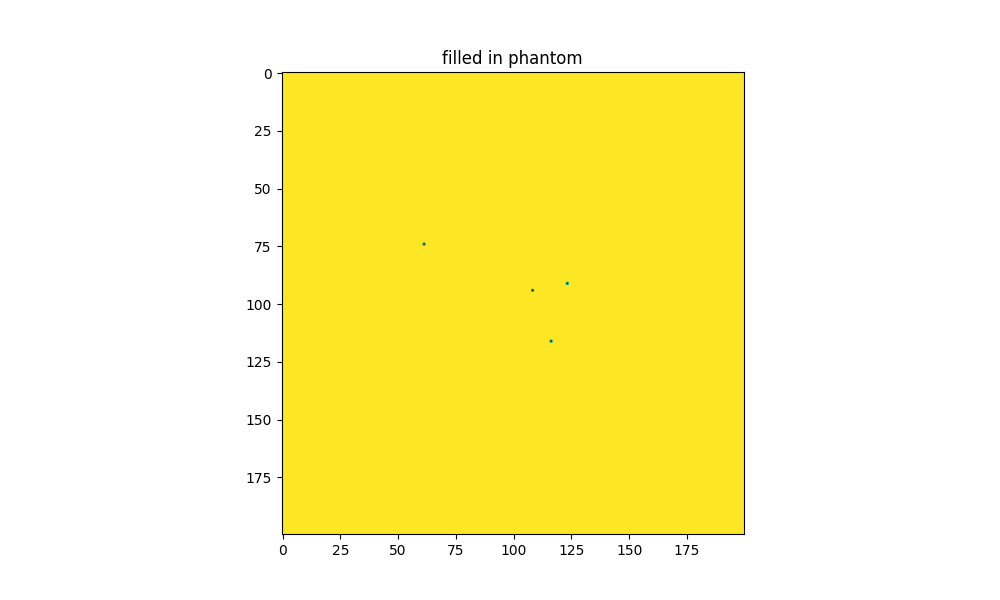

In [10]:
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []


def init():
    frames.append(axes.imshow(solver_obj._x[:,:,0]))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(solver_obj._x[:,:,i])

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))

In [11]:
# from opticaltomography.forward_3dri import PhaseObject3D, TomographySolver
# ---------------------------#
# Generate forward prediction
# ---------------------------#
forward_field_mb, fields = solver_obj.forwardPredict(obj=solver_obj._x)

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

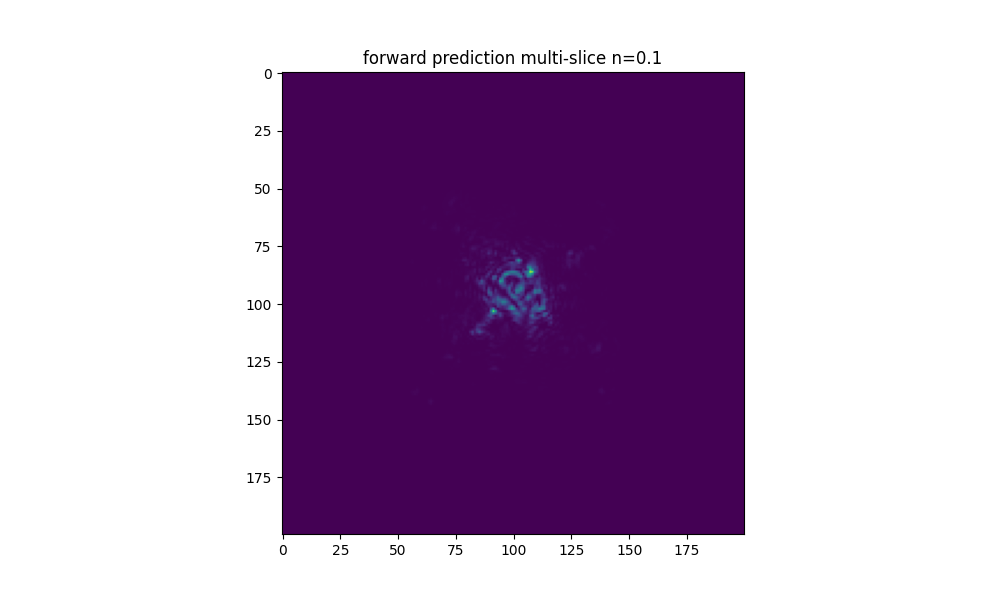

In [14]:
# ---------------------------#
# Show forward prediction
# ---------------------------#
# forward_field_mb[0].shape

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes.imshow(forward_field_mb[0],vmin=0,vmax=0.1))
    axes.set_title('forward prediction multi-slice n=0.1')

init()

def updateFrames(i):
    # img = torch.fft.fftshift(torch.abs(solver_obj.test_spherical[i]))
    # frames.append(axes.imshow(img))
    frames[0].set_data(forward_field_mb[i])

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

In [ ]:
"""
test = solver_obj._scattering_obj.test_prop

f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes.imshow(torch.abs(test[0])))
    axes.set_title('forward prediction')

init()

def updateFrames(i):
    # img = torch.fft.fftshift(torch.abs(solver_obj.test_spherical[i]))
    # frames.append(axes.imshow(img))
    frames[0].set_data(torch.abs(test[i]))

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))
"""

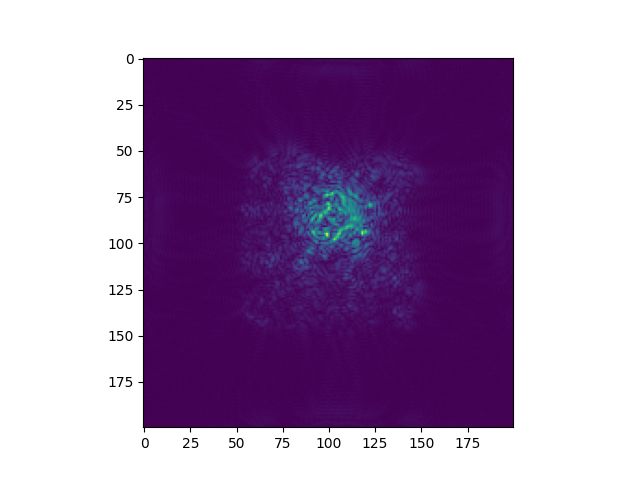

In [18]:
# plt.figure()
# plt.imshow(np.abs(solver_obj._aberration_obj.test_real))

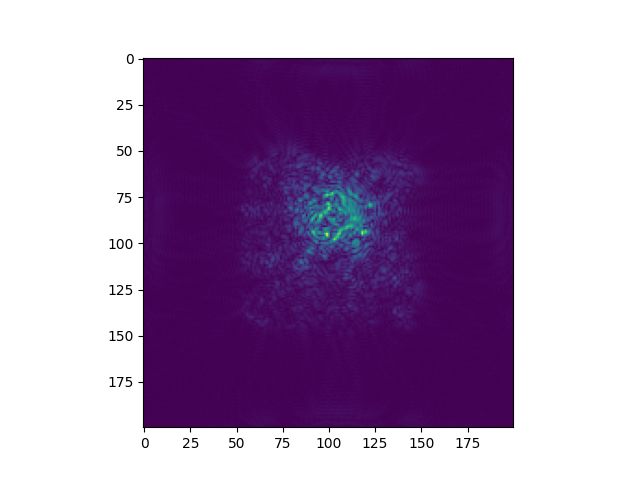

In [27]:
# plt.figure()
# plt.imshow(solver_obj.abs_field)